# [Фінальний проєкт](https://www.edu.goit.global/uk/learn/25315460/23598278/26258114/homework)
___

## Kaggle: [ML: Fundamentals and Applications 2025-03](https://www.kaggle.com/competitions/ml-fundamentals-and-applications-2025-03/leaderboard)

## Імпорт необхідних модулів

In [1]:
import datetime
import os
import warnings
import pandas as pd
import pandas.api.types
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
import matplotlib.gridspec as gridspec
from sklearn.decomposition import PCA

from typing import Sequence, Union, Optional
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.feature_selection import RFECV, RFE, SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, SMOTENC
from imblearn.combine import SMOTETomek
from sklearn.calibration import LabelEncoder
from xgboost import XGBClassifier
from sklearn.ensemble import (
    RandomForestRegressor,
    RandomForestClassifier,
    GradientBoostingRegressor,
    GradientBoostingClassifier,
    VotingClassifier,
)
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    PowerTransformer,
    RobustScaler,
    PolynomialFeatures,
)
from sklearn.metrics import (
    balanced_accuracy_score,
    make_scorer,
    mean_absolute_error,
    mean_squared_error,
    mean_absolute_percentage_error,
    r2_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedKFold,
    learning_curve,
    cross_val_score,
    train_test_split,
)

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

## Kaggle metric utilities

In [2]:
"""
This script exists to reduce code duplication across metrics.
"""

import numpy as np
import pandas as pd
import pandas.api.types

from typing import Union


class ParticipantVisibleError(Exception):
    pass


class HostVisibleError(Exception):
    pass


def treat_as_participant_error(
    error_message: str, solution: Union[pd.DataFrame, np.ndarray]
) -> bool:
    """Many metrics can raise more errors than can be handled manually. This function attempts
    to identify errors that can be treated as ParticipantVisibleError without leaking any competition data.

    If the solution is purely numeric, and there are no numbers in the error message,
    then the error message is sufficiently unlikely to leak usable data and can be shown to participants.

    We expect this filter to reject many safe messages. It's intended only to reduce the number of errors we need to manage manually.
    """
    # This check treats bools as numeric
    if isinstance(solution, pd.DataFrame):
        solution_is_all_numeric = all(
            [pandas.api.types.is_numeric_dtype(x) for x in solution.dtypes.values]
        )
        solution_has_bools = any(
            [pandas.api.types.is_bool_dtype(x) for x in solution.dtypes.values]
        )
    elif isinstance(solution, np.ndarray):
        solution_is_all_numeric = pandas.api.types.is_numeric_dtype(solution)
        solution_has_bools = pandas.api.types.is_bool_dtype(solution)

    if not solution_is_all_numeric:
        return False

    for char in error_message:
        if char.isnumeric():
            return False
    if solution_has_bools:
        if "true" in error_message.lower() or "false" in error_message.lower():
            return False
    return True


def safe_call_score(metric_function, solution, submission, **metric_func_kwargs):
    """
    Call score. If that raises an error and that already been specifically handled, just raise it.
    Otherwise make a conservative attempt to identify potential participant visible errors.
    """
    try:
        score_result = metric_function(solution, submission, **metric_func_kwargs)
    except Exception as err:
        error_message = str(err)
        if err.__class__.__name__ == "ParticipantVisibleError":
            raise ParticipantVisibleError(error_message)
        elif err.__class__.__name__ == "HostVisibleError":
            raise HostVisibleError(error_message)
        else:
            if treat_as_participant_error(error_message, solution):
                raise ParticipantVisibleError(error_message)
            else:
                raise err
    # Explicit float conversion prevents issues with numbers stored as np.float64 scalars
    return float(score_result)


def verify_valid_probabilities(df: pd.DataFrame, df_name: str):
    """Verify that the dataframe contains valid probabilities.

    The dataframe must be limited to the target columns; do not pass in any ID columns.
    """
    if not pandas.api.types.is_numeric_dtype(df.values):
        raise ParticipantVisibleError(f"All target values in {df_name} must be numeric")

    if df.min().min() < 0:
        raise ParticipantVisibleError(
            f"All target values in {df_name} must be at least zero"
        )

    if df.max().max() > 1:
        raise ParticipantVisibleError(
            f"All target values in {df_name} must be no greater than one"
        )

    if not np.allclose(df.sum(axis=1), 1):
        raise ParticipantVisibleError(
            f"Target values in {df_name} do not add to one within all rows"
        )


class ParticipantVisibleError(Exception):
    pass


def score(
    solution: pd.DataFrame,
    submission: pd.DataFrame,
    row_id_column_name: str,
    weights_column_name: Optional[str] = None,
    adjusted: bool = False,
) -> float:
    """
    Wrapper for https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
    Compute the balanced accuracy.

    The balanced accuracy in binary and multiclass classification problems to
    deal with imbalanced datasets. It is defined as the average of recall
    obtained on each class.

    The best value is 1 and the worst value is 0 when ``adjusted=False``.

    Parameters
    ----------
    solution : 1d DataFrame
    Ground truth (correct) target values.

    submission : 1d DataFrame
    Estimated targets as returned by a classifier.

    weights_column_name: optional str, the name of the sample weights column in the solution file.

    adjusted : bool, default=False
    When true, the result is adjusted for chance, so that random
    performance would score 0, while keeping perfect performance at a score
    of 1.

    References
    ----------
    .. [1] Brodersen, K.H.; Ong, C.S.; Stephan, K.E.; Buhmann, J.M. (2010).
    The balanced accuracy and its posterior distribution.
    Proceedings of the 20th International Conference on Pattern
    Recognition, 3121-24.
    .. [2] John. D. Kelleher, Brian Mac Namee, Aoife D'Arcy, (2015).
    `Fundamentals of Machine Learning for Predictive Data Analytics:
    Algorithms, Worked Examples, and Case Studies
    <https://mitpress.mit.edu/books/fundamentals-machine-learning-predictive-data-analytics>`_.

    Examples
    --------

    >>> import pandas as pd
    >>> row_id_column_name = "id"
    >>> y_true = [0, 1, 0, 0, 1, 0]
    >>> y_true = pd.DataFrame(y_true)
    >>> y_true["id"] = range(len(y_true))
    >>> y_pred = [0, 1, 0, 0, 0, 1]
    >>> y_pred = pd.DataFrame(y_pred)
    >>> y_pred["id"] = range(len(y_pred))
    >>> score(y_true.copy(), y_pred.copy(), row_id_column_name)
    0.625
    """
    # Skip sorting and equality checks for the row_id_column since that should already be handled
    del solution[row_id_column_name]
    del submission[row_id_column_name]

    sample_weight = None
    if weights_column_name:
        if weights_column_name not in solution.columns:
            raise ValueError(
                f"The solution weights column {weights_column_name} is not found"
            )
        sample_weight = solution.pop(weights_column_name).values
        if not pandas.api.types.is_numeric_dtype(sample_weight):
            raise ParticipantVisibleError("The solution weights are not numeric")

    if len(submission.columns) > 1:
        raise ParticipantVisibleError(
            f"The submission can only include one column of predictions. Found {len(submission.columns)}"
        )

    solution = solution.values
    submission = submission.values

    score_result = safe_call_score(
        balanced_accuracy_score,
        solution,
        submission,
        sample_weight=sample_weight,
        adjusted=adjusted,
    )

    return score_result

## Завантаження даних

In [3]:
PATH_TO_DATASETS = os.path.expanduser(
    "~/Projects/GoIT/MACHINE-LEARNING-NEO/datasets/final/data"
)
PATH_TO_RESULTS = os.path.expanduser(
    "~/Projects/GoIT/MACHINE-LEARNING-NEO/datasets/final/results"
)
os.makedirs(PATH_TO_RESULTS, exist_ok=True)
print(PATH_TO_DATASETS)
print(PATH_TO_RESULTS)

train_file = os.path.join(PATH_TO_DATASETS, "final_proj_data.csv")
test_file = os.path.join(PATH_TO_DATASETS, "final_proj_test.csv")

/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/datasets/final/data
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/datasets/final/results


In [4]:
# "customer churn"
TARGET = "y"
train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print(f"Training data shape: {train_df.shape}")
display(train_df.head())
print(f"Test data shape: {test_df.shape}")
display(test_df.head())

Training data shape: (10000, 231)


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,NaN,NaN,1252.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,0.0,40.0,NaN,NaN,286.96,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4850466.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.368725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,NaN,NaN,NaN,9.0,150,14.0,NaN,2958048.0,NaN,0.0,NaN,NaN,227693.10,NaN,15.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1698.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,48.0,175099.6,NaN,NaN,NaN,NaN,NaN,525.0,NaN,NaN,NaN,60.0,NaN,4743.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,5295550.0,348816.0,NaN,NaN,NaN,NaN,NaN,410.0,NaN,NaN,0.0,27.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,10683560.0,NaN,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,KXMrEyXXnK,g62hiBSaKg,SEuy,taul,1K8T,IvdZ,fhk21Ss,Pkku4gO,pbHkKHa,smXZ,4MV4,9_Y1,SkZj,VpdQ,itlM,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,WsRVNrF85oPU_,NaN,E4QF4eX,NaN,11pRpOD,G8WR,cJvF,AU8_WTd,4UxGlow,zCkv,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,NaN,NaN,8820.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,364.0,455.0,NaN,4.0,288.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,132072.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.159795,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140,210.0,NaN,1095032.0,NaN,0.0,NaN,NaN,17662.35,NaN,50.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,NaN,NaN,96.0,146784.8,NaN,NaN,NaN,NaN,NaN,1065.0,NaN,NaN,NaN,48.0,NaN,44541.0,50.0,NaN,NaN,NaN,NaN,NaN,0.0,468860.0,364586.0,NaN,NaN,NaN,NaN,NaN,60.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,398034.0,NaN,NaN,NaN,2230420.0,NaN,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,503406.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,258.0,NaN,NaN,8Knvyx875g,2Knk1KF,SEuy,taul,1K8T,lK27,eQgnKxT,Hz673939hbJdw,ELe4G18,smXZ,sbhw,9_Y1,MBhA,VpdQ,lVqb,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,kfKvbJ9,NaN,11pEY2j,5smi,UYBR,AU8pNoi,GpvRJ5l,oslk,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,NaN,NaN,1784.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.0,170.0,NaN,2.0,40.0,NaN,NaN,294.48,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3223524.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.483871,NaN,NaN,NaN,NaN,NaN,

Test data shape: (2500, 230)


,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,Var41,Var42,Var43,Var44,Var45,Var46,Var47,Var48,Var49,Var50,Var51,Var52,Var53,Var54,Var55,Var56,Var57,Var58,Var59,Var60,Var61,Var62,Var63,Var64,Var65,Var66,Var67,Var68,Var69,Var70,Var71,Var72,Var73,Var74,Var75,Var76,Var77,Var78,Var79,Var80,Var81,Var82,Var83,Var84,Var85,Var86,Var87,Var88,Var89,Var90,Var91,Var92,Var93,Var94,Var95,Var96,Var97,Var98,Var99,Var100,Var101,Var102,Var103,Var104,Var105,Var106,Var107,Var108,Var109,Var110,Var111,Var112,Var113,Var114,Var115,Var116,Var117,Var118,Var119,Var120,Var121,Var122,Var123,Var124,Var125,Var126,Var127,Var128,Var129,Var130,Var131,Var132,Var133,Var134,Var135,Var136,Var137,Var138,Var139,Var140,Var141,Var142,Var143,Var144,Var145,Var146,Var147,Var148,Var149,Var150,Var151,Var152,Var153,Var154,Var155,Var156,Var157,Var158,Var159,Var160,Var161,Var162,Var163,Var164,Var165,Var166,Var167,Var168,Var169,Var170,Var171,Var172,Var173,Var174,Var175,Var176,Var177,Var178,Var179,Var180,Var181,Var182,Var183,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,819.0,7.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.0,200.0,NaN,2.0,56.0,NaN,NaN,403.36,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4800036.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.667165,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168,0.0,NaN,3801816.0,NaN,0.0,NaN,NaN,186732.90,NaN,15.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN,NaN,48.0,159149.600,NaN,NaN,NaN,NaN,NaN,595.0,NaN,NaN,NaN,78.0,NaN,5688.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,4101810.0,807760.0,NaN,NaN,NaN,NaN,NaN,20.0,NaN,NaN,0.0,18.0,NaN,NaN,NaN,NaN,554435.0,NaN,NaN,NaN,10948360.0,NaN,NaN,NaN,NaN,NaN,NaN,22.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75lTmBtFkL,rEUOq2QD1qfkRr6qpua,NaN,taul,1K8T,F9g8,fhk21Ss,GVWDufEPyV,3VuKz0_,NaN,GHne,9_Y1,c2JP,VpdQ,hAFG,7M47J5GA0pTYIFxg5uy,kIsH,NaN,uKAI,L84s,oOT00mkwDoEFW,NaN,XZ6TpvF,NaN,pMW8rnA,6ITF,cJvF,FzaX,4UxGlow,zCkv,catzS2D,LM8l689qOp,NaN,ELof,rgKb,ZI9m,ib5G6X1eUxUn6,am7c,NaN
1,NaN,NaN,NaN,NaN,NaN,3192.0,28.0,NaN,NaN,NaN,NaN,NaN,3864.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,475.0,NaN,8.0,288.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,51282.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.056398,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45.0,NaN,NaN,NaN,NaN,NaN,NaN,12.0,46,518.0,NaN,1217520.0,NaN,0.0,NaN,NaN,13126.62,NaN,5.0,NaN,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17214.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,152.0,NaN,NaN,80.0,1258.428,NaN,NaN,NaN,NaN,NaN,1320.0,NaN,NaN,NaN,36.0,NaN,16470.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,689795.0,327752.0,NaN,NaN,NaN,NaN,NaN,1835.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,NaN,280392.0,NaN,NaN,NaN,2101956.0,NaN,NaN,NaN,NaN,NaN,NaN,46.0,NaN,NaN,375756.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,300.0,NaN,NaN,1YVgUHXZeb,RO12,NaN,taul,1K8T,0Xwj,Ml6kiFp,S85OeCBjSz,NaN,NaN,14hG,HLqf,8BBI,09_Q,43pnToF,me75fM6ugJ,sBgB,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,mAjbk_S,RRN_,UYBR,FzaX,k5O88FJ,oslk,QkgQQMs,LM8l689qOp,NaN,NaN,453m,RAYp,F2FyR07IdsN7I,am7c,NaN
2,NaN,NaN,NaN,NaN,NaN,756.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,156.0,195.0,NaN,2.0,40.0,NaN,NaN,402.24,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3462336.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.020936,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,NaN,NaN

## EDA

### Перевірка типів даних і відсутніх значень

Training data shape: (10000, 231)
Test data shape: (2500, 230)

Data types in training set:
float64    191
object      38
int64        2
Name: count, dtype: int64

Features with missing values:
        Missing Count  Missing Percent
Var8            10000           100.00
Var15           10000           100.00
Var55           10000           100.00
Var48           10000           100.00
Var42           10000           100.00
...               ...              ...
Var218            128             1.28
Var192             79             0.79
Var197             28             0.28
Var203             28             0.28
Var208             28             0.28

[209 rows x 2 columns]


<Axes: >

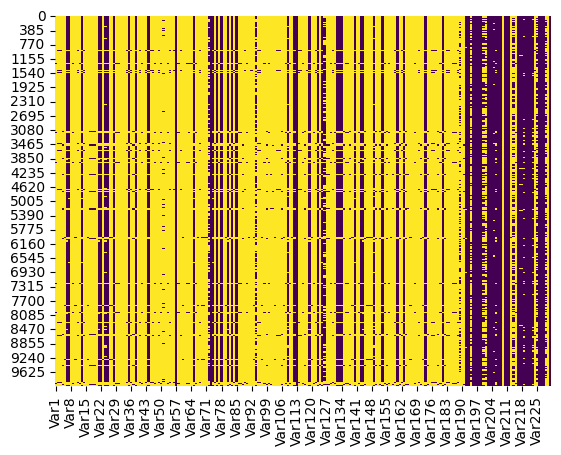

In [5]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

print("\nData types in training set:")
print(train_df.dtypes.value_counts())

# Analyze missing values
missing_summary = train_df.isnull().sum()
missing_percent = (missing_summary / len(train_df)) * 100
missing_data = pd.DataFrame({'Missing Count': missing_summary, 
                            'Missing Percent': missing_percent})
missing_data = missing_data[missing_data['Missing Count'] > 0].sort_values('Missing Percent', ascending=False)

print("\nFeatures with missing values:")
print(missing_data)

sns.heatmap(train_df.isna(), cbar=False, cmap="viridis")

#### Видаляємо пусті колонки

Removing 18 completely empty columns: ['Var8', 'Var15', 'Var20', 'Var31', 'Var32', 'Var39', 'Var42', 'Var48', 'Var52', 'Var55', 'Var79', 'Var141', 'Var167', 'Var169', 'Var175', 'Var185', 'Var209', 'Var230']


<Axes: >

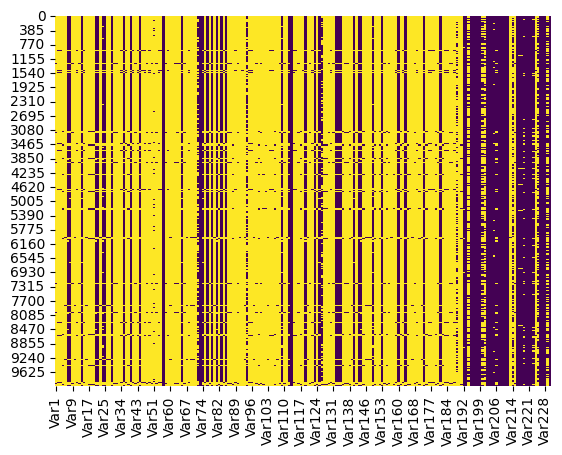

In [6]:
columns_to_drop = missing_summary[missing_summary == len(train_df)].index.tolist()
if columns_to_drop:
    print(f"Removing {len(columns_to_drop)} completely empty columns: {columns_to_drop}")
    train_df.drop(columns=columns_to_drop, inplace=True)
    test_df.drop(columns=columns_to_drop, errors="ignore", inplace=True)

sns.heatmap(train_df.isna(), cbar=False, cmap="viridis")

### Видаляємо пусті рядки

In [7]:
empty_rows_train = train_df.isna().all(axis=1).sum()
print(f"Number of completely empty rows in training data: {empty_rows_train} out of {len(train_df)} ({empty_rows_train/len(train_df)*100:.2f}%)")

empty_rows_test = test_df.isna().all(axis=1).sum()
print(f"Number of completely empty rows in test data: {empty_rows_test} out of {len(test_df)} ({empty_rows_test/len(test_df)*100:.2f}%)")

train_df_cleaned = train_df.dropna(how='all')
test_df_cleaned = test_df.dropna(how='all')

print(f"Removed {len(train_df) - len(train_df_cleaned)} rows from training data")
print(f"Removed {len(test_df) - len(test_df_cleaned)} rows from test data")

train_df = train_df_cleaned
test_df = test_df_cleaned

print(f"New training data shape: {train_df.shape}")
print(f"New test data shape: {test_df.shape}")

Number of completely empty rows in training data: 0 out of 10000 (0.00%)
Number of completely empty rows in test data: 0 out of 2500 (0.00%)
Removed 0 rows from training data
Removed 0 rows from test data
New training data shape: (10000, 213)
New test data shape: (2500, 212)


### Розподіл

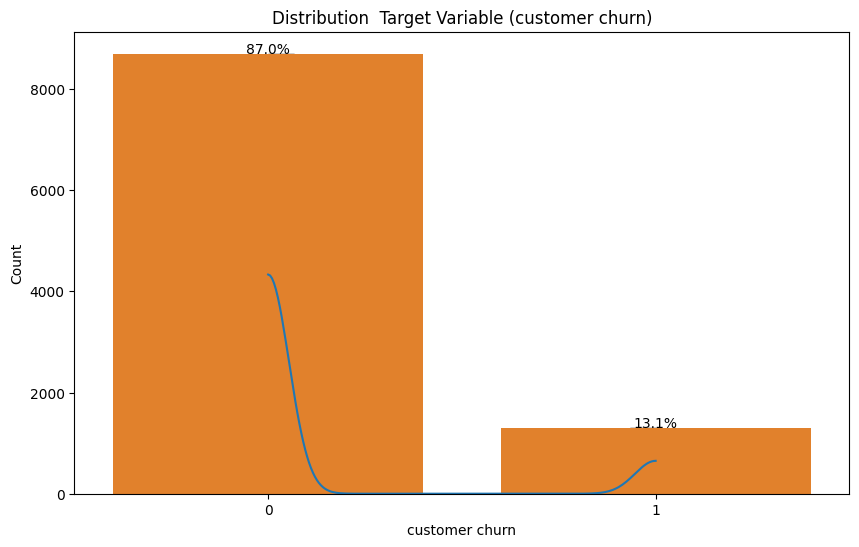


Class imbalance ratio (majority:minority): 6.66


In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df[TARGET], kde=True)
plt.title("Distribution  Target Variable (customer churn)")
plt.xlabel("customer churn")
target_counts = train_df[TARGET].value_counts()
ax = sns.countplot(x=TARGET, data=train_df)
for i, count in enumerate(target_counts):
    percentage = 100 * count / len(train_df)
    ax.text(i, count + 5, f"{percentage:.1f}%", ha='center')
plt.show()

class_imbalance = train_df[TARGET].value_counts().max() / train_df[TARGET].value_counts().min()
print(f"\nClass imbalance ratio (majority:minority): {class_imbalance:.2f}")

### Feature Analysis

In [9]:
X = train_df.drop(columns=[TARGET], errors="ignore")
y = train_df[TARGET]
print(f"\nX shape: {X.shape}")
print(f"y shape: {y.shape}")
num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

print(f"\nNumeric features: {len(num_features)}")
print(f"Categorical features: {len(cat_features)}")


X shape: (10000, 212)
y shape: (10000,)

Numeric features: 174
Categorical features: 38


### Categorical features

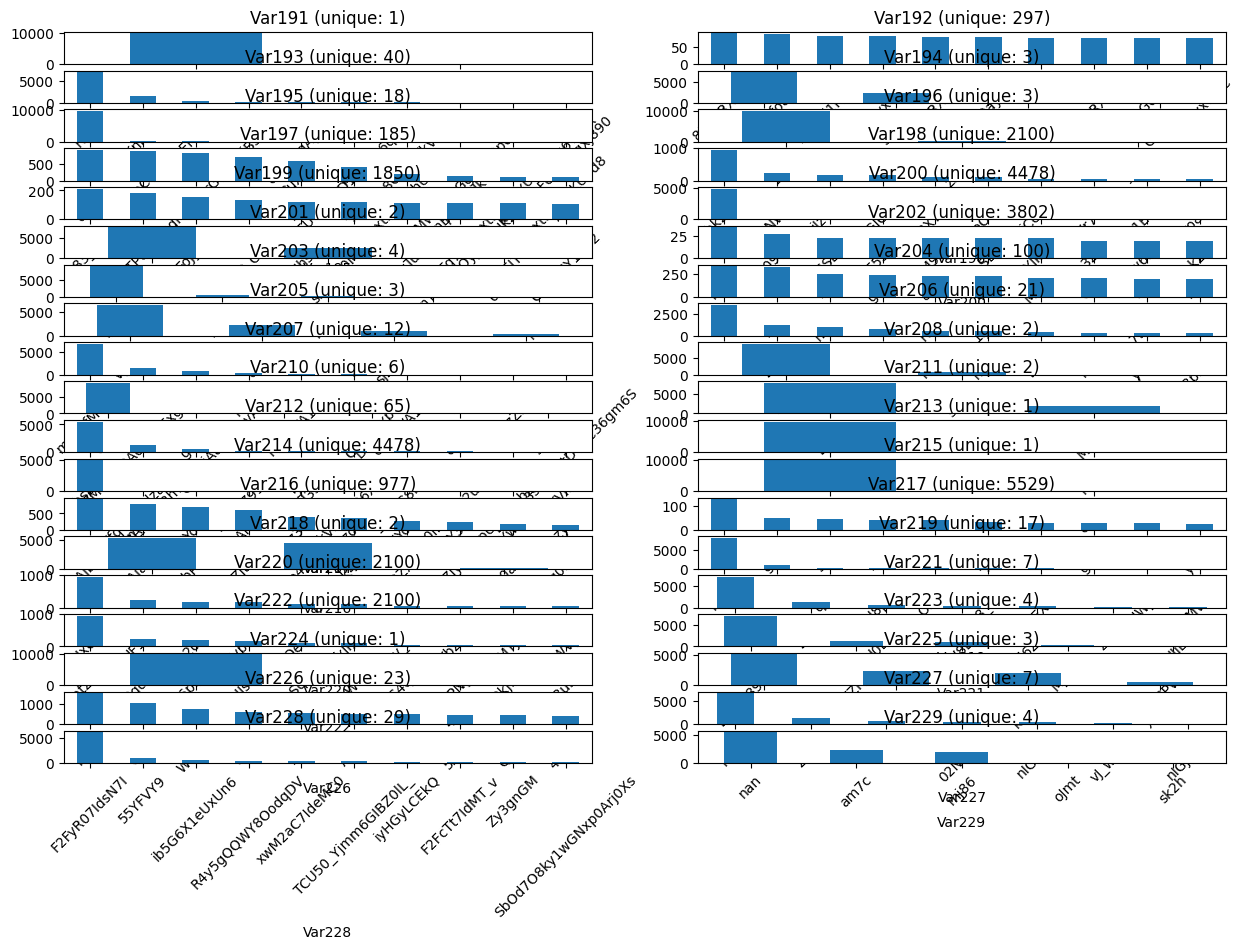

Unique values in categorical columns:
Var191: 1 unique values
    Values: [nan 'r__I']
Var192: 297 unique values
    Sample values: ['KXMrEyXXnK' '8Knvyx875g' 'MfKrEyQtC3' 'Qu0qrQKzJV' 'DHerjIKQ76'] ...
Var193: 40 unique values
    Sample values: ['g62hiBSaKg' '2Knk1KF' 'RO12' 'AERks4l' 'e6CkoqApVR'] ...
Var194: 3 unique values
    Values: ['SEuy' nan 'lvza' 'CTUH']
Var195: 18 unique values
    Sample values: ['taul' 'CiJDdr4TQ0rGERIS' 'LfvqpCtLOY' 'I9xt3GDRhUK7p' 'ev6I'] ...
Var196: 3 unique values
    Values: ['1K8T' 'z3mO' 'JA1C']
Var197: 185 unique values
    Sample values: ['IvdZ' 'lK27' '487l' 'YPhp' 'hM6W'] ...
Var198: 2100 unique values
    Sample values: ['fhk21Ss' 'eQgnKxT' 'iJzviRg' '3cunsla' '65ylkJq'] ...
Var199: 1850 unique values
    Sample values: ['Pkku4gO' 'Hz673939hbJdw' '76j2P_OLn0' 'ZIX6Y9cVy5' 'glRbITbnHQ'] ...
Var200: 4478 unique values
    Sample values: ['pbHkKHa' 'ELe4G18' 'pOtdZA9' nan '3VuBL38'] ...
Var201: 2 unique values
    Values: ['smXZ' nan '6dX3']
Var

In [10]:
if (cat_features):
    plt.figure(figsize=(15, 10))
    gs = gridspec.GridSpec(len(cat_features) // 2 + 1, 2)

    for i, feature in enumerate(cat_features):
        ax = plt.subplot(gs[i // 2, i % 2])

        unique_count = train_df[feature].dropna().nunique()
        value_counts = train_df[feature].value_counts(dropna=False).head(10)
        value_counts.plot(kind='bar', ax=ax)
        ax.set_title(f"{feature} (unique: {unique_count})")
        ax.tick_params(axis='x', rotation=45)
        plt.tight_layout()

    plt.show()

print(f"Unique values in categorical columns:")
for col in train_df.select_dtypes(include=["object"]).columns:
    print(f"{col}: {train_df[col].nunique()} unique values")

    unique_values = train_df[col].unique()
    if len(unique_values) <= 10:
        print(f"    Values: {unique_values}")
    else:
        print(f"    Sample values: {unique_values[:5]} ...")

### Numeric features

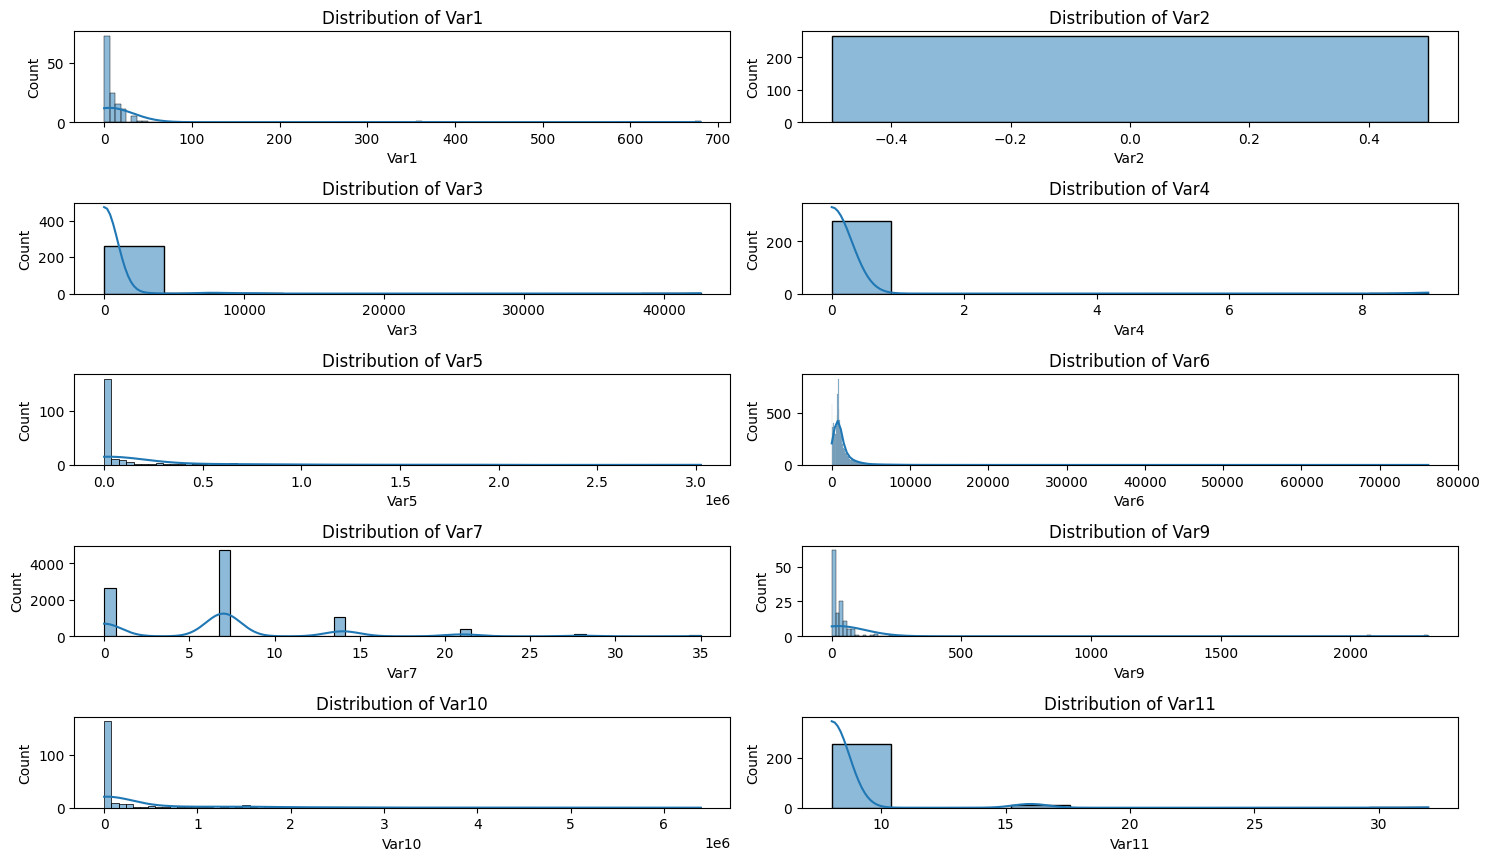

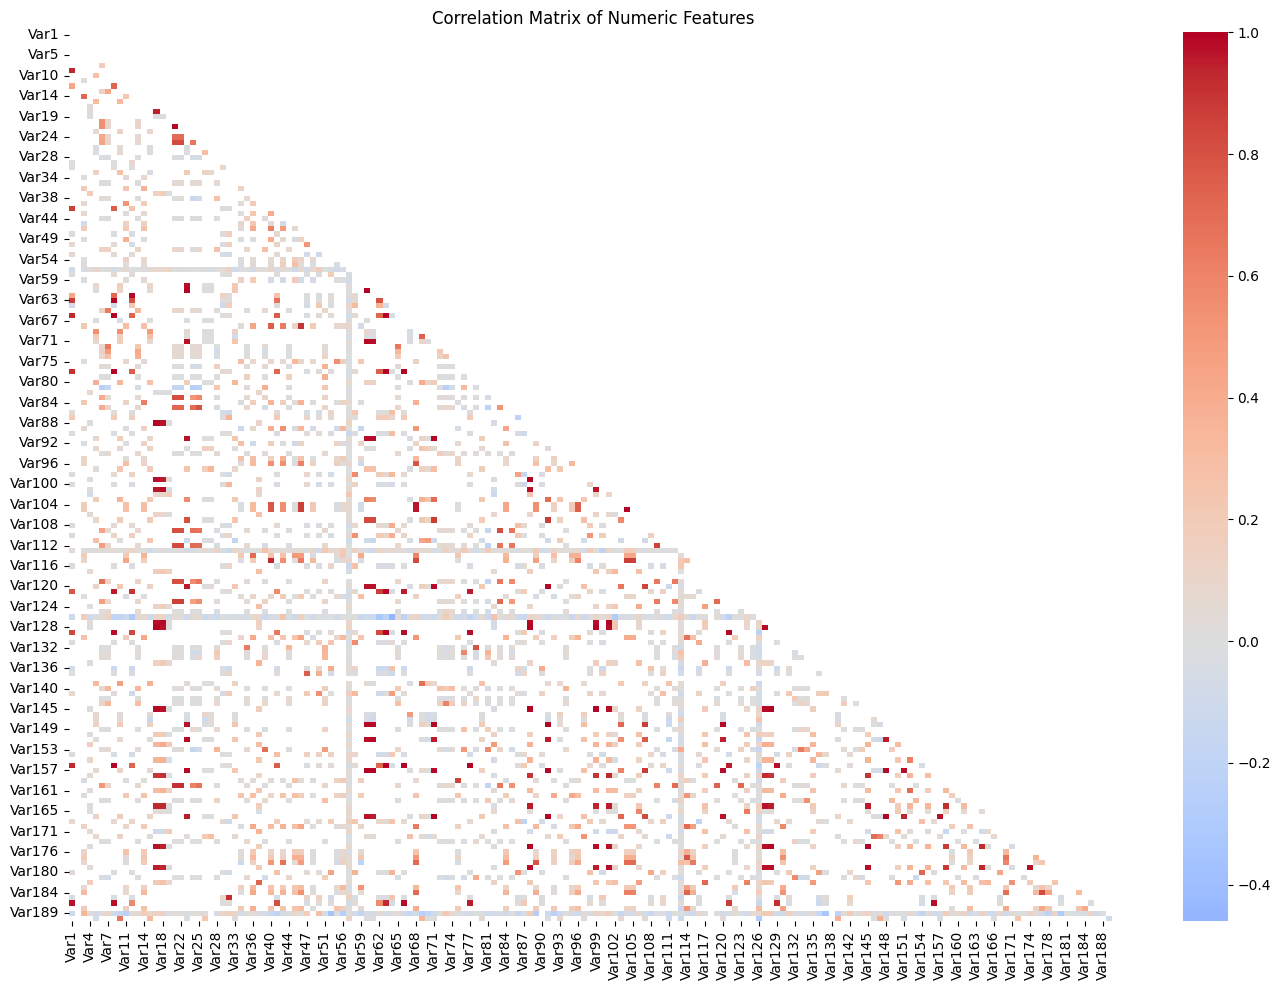

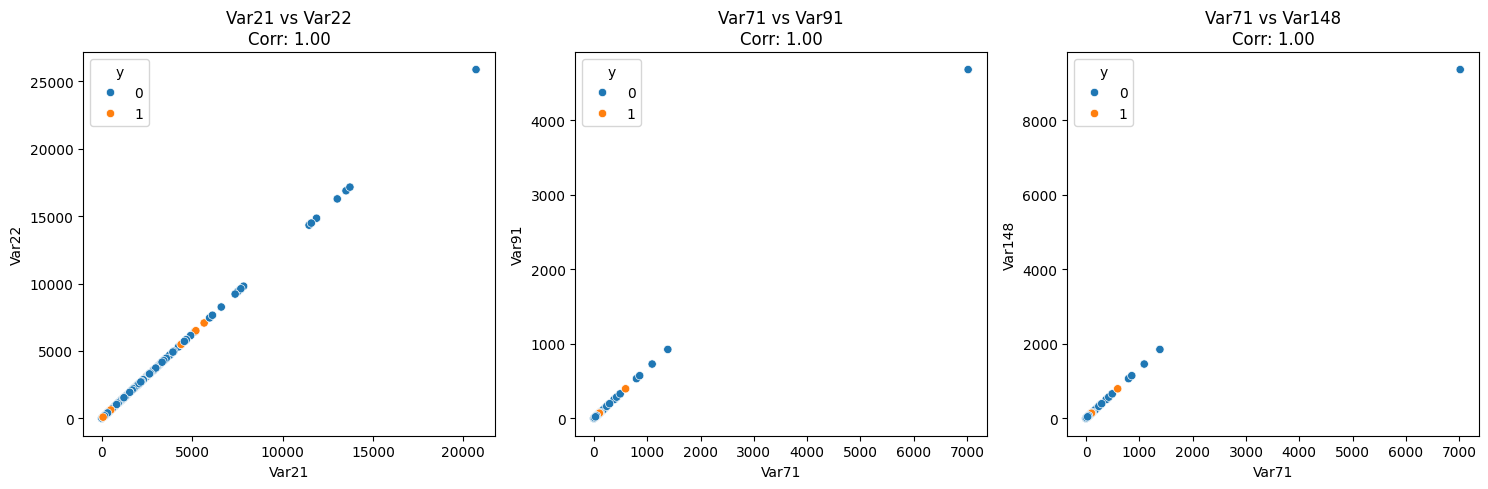


Highly correlated feature pairs:
Var21 and Var22: 1.00
Var71 and Var91: 1.00
Var71 and Var148: 1.00
Var91 and Var148: 1.00
Var104 and Var105: 1.00
Var88 and Var145: 1.00
Var66 and Var156: 1.00
Var128 and Var145: 1.00
Var88 and Var128: 1.00
Var9 and Var66: 1.00
Var9 and Var156: 1.00
Var61 and Var157: 0.99
Var99 and Var128: 0.99
Var88 and Var99: 0.99
Var99 and Var145: 0.99
Var60 and Var157: 0.99
Var101 and Var127: 0.99
Var63 and Var129: 0.99
Var9 and Var77: 0.99
Var66 and Var77: 0.99
Var77 and Var156: 0.99
Var23 and Var61: 0.99
Var88 and Var174: 0.99
Var128 and Var174: 0.99
Var60 and Var61: 0.99
Var145 and Var174: 0.99
Var9 and Var63: 0.99
Var63 and Var66: 0.99
Var63 and Var156: 0.99
Var71 and Var166: 0.99
Var91 and Var166: 0.99
Var148 and Var166: 0.99
Var17 and Var128: 0.99
Var17 and Var88: 0.99
Var63 and Var77: 0.99
Var71 and Var157: 0.99
Var91 and Var157: 0.99
Var148 and Var157: 0.99
Var121 and Var129: 0.99
Var127 and Var128: 0.99
Var88 and Var127: 0.99
Var127 and Var145: 0.99
Var12 

In [11]:
plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(min(10, len(num_features)) // 2 + 1, 2)

# Show first 10 features
for i, feature in enumerate(num_features[:10]):
    ax = plt.subplot(gs[i // 2, i % 2])
    sns.histplot(train_df[feature].dropna(), kde=True, ax=ax)
    ax.set_title(f"Distribution of {feature}")
    plt.tight_layout()

plt.show()

# Correlation matrix
plt.figure(figsize=(14, 10))
numeric_data = train_df[num_features].copy()
corr_matrix = numeric_data.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', annot=False, center=0)
plt.title("Correlation Matrix of Numeric Features")
plt.tight_layout()
plt.show()

high_corr_threshold = 0.8
high_corr_features = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > high_corr_threshold:
            feat_pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
            high_corr_features.append(feat_pair)
            high_corr_features.sort(key=lambda x: abs(x[2]), reverse=True)

if high_corr_features:
    top_n = min(3, len(high_corr_features))
    fig, axes = plt.subplots(1, top_n, figsize=(15, 5))
    if top_n == 1:
        axes = [axes]
    
    for i in range(top_n):
        feat1, feat2, corr = high_corr_features[i]
        sns.scatterplot(x=train_df[feat1], y=train_df[feat2], hue=train_df[TARGET], ax=axes[i])
        axes[i].set_title(f"{feat1} vs {feat2}\nCorr: {corr:.2f}")
        axes[i].set_xlabel(feat1)
        axes[i].set_ylabel(feat2)
    
    plt.tight_layout()
    plt.show()

    print("\nHighly correlated feature pairs:")
    for feat1, feat2, corr in high_corr_features:
        print(f"{feat1} and {feat2}: {corr:.2f}")

In [12]:
if high_corr_features:
    print(f"\nRemoving {len(high_corr_features)} highly correlated features:")
    for feat1, feat2, corr in high_corr_features:
        # if corr == 1:
            # Check if the feature exists before trying to drop it
        if feat2 in train_df.columns:
            print(f"Removing {feat2} due to perfect correlation with {feat1}")
            train_df.drop(columns=feat2, errors="ignore", inplace=True)
            test_df.drop(columns=feat2, errors="ignore", inplace=True)
else:
    print("\nNo highly correlated features to remove.")

   
print(f"New training data shape: {train_df.shape}")
print(f"New test data shape: {test_df.shape}")


Removing 193 highly correlated features:
Removing Var22 due to perfect correlation with Var21
Removing Var91 due to perfect correlation with Var71
Removing Var148 due to perfect correlation with Var71
Removing Var105 due to perfect correlation with Var104
Removing Var145 due to perfect correlation with Var88
Removing Var156 due to perfect correlation with Var66
Removing Var128 due to perfect correlation with Var88
Removing Var66 due to perfect correlation with Var9
Removing Var157 due to perfect correlation with Var61
Removing Var99 due to perfect correlation with Var88
Removing Var127 due to perfect correlation with Var101
Removing Var129 due to perfect correlation with Var63
Removing Var77 due to perfect correlation with Var9
Removing Var61 due to perfect correlation with Var23
Removing Var174 due to perfect correlation with Var88
Removing Var63 due to perfect correlation with Var9
Removing Var166 due to perfect correlation with Var71
Removing Var88 due to perfect correlation with V

### Важливість ознак

#### RandomForestClassifier


Running preliminary feature importance analysis...


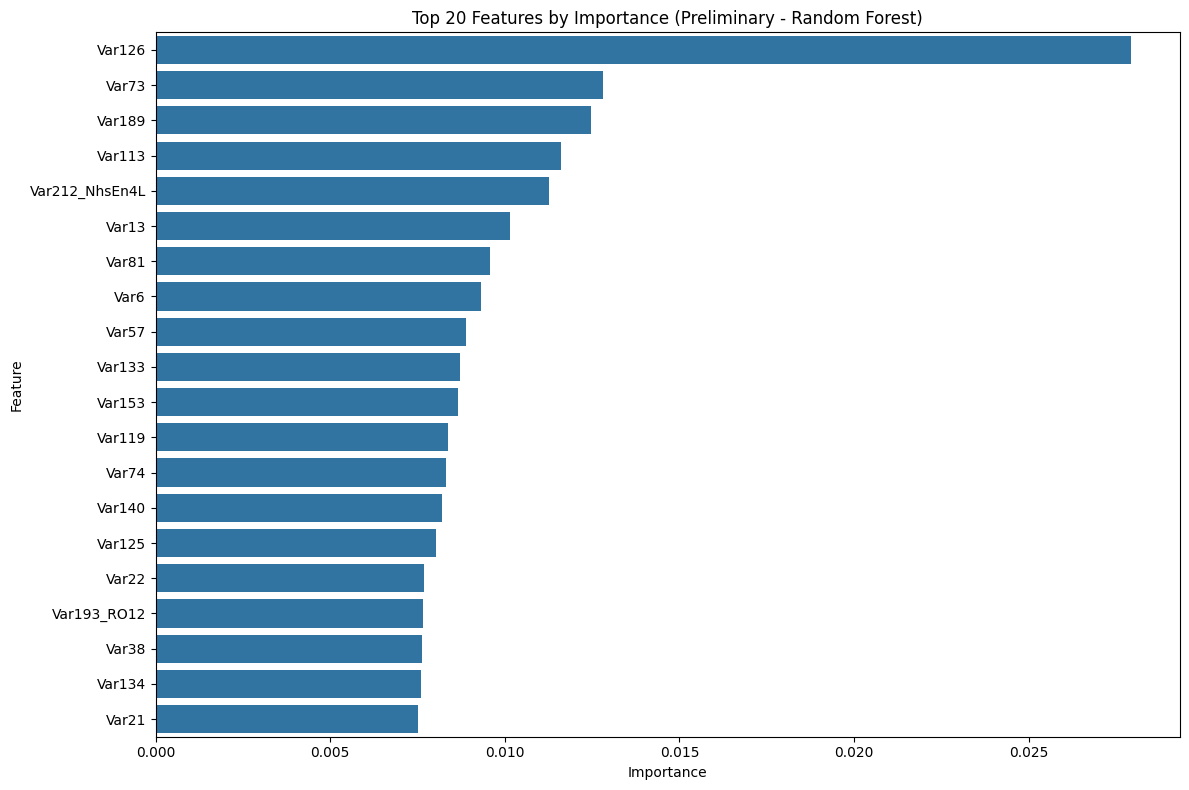

In [13]:
X_sample = X.copy()

for col in num_features:
    X_sample[col] = X_sample[col].fillna(X_sample[col].median())
for col in cat_features:
    X_sample[col] = X_sample[col].fillna(X_sample[col].mode()[0] if not X_sample[col].mode().empty else "Unknown")

X_encoded = pd.get_dummies(X_sample, columns=cat_features, drop_first=True)

print("\nRunning preliminary feature importance analysis...")
rf_prelim = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_prelim.fit(X_encoded, y)

feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'Importance': rf_prelim.feature_importances_
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Features by Importance (Preliminary - Random Forest)')
plt.tight_layout()
plt.show()

#### PCA

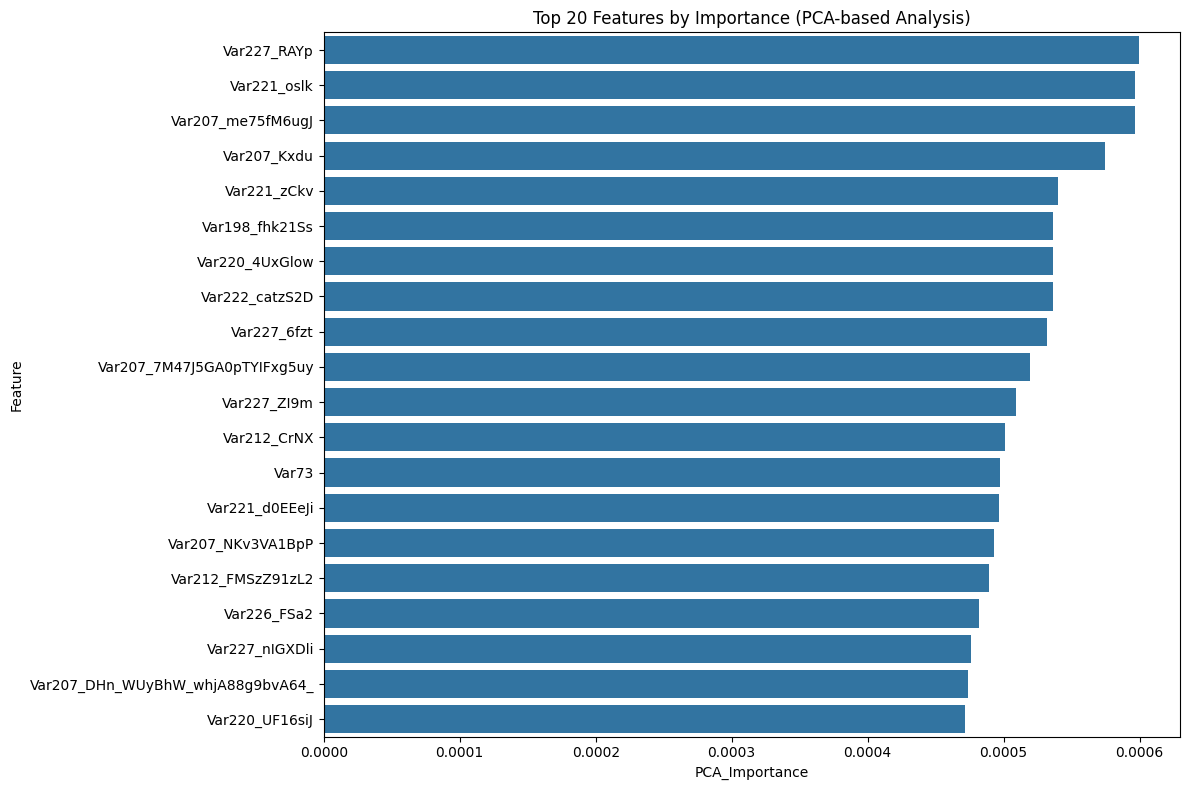

In [14]:
X_scaled = StandardScaler().fit_transform(X_encoded)
    
pca = PCA(n_components=min(20, X_scaled.shape[1]))
pca.fit(X_scaled)

loadings = pca.components_.T
explained_variance_ratio = pca.explained_variance_ratio_

pca_importance = np.zeros(loadings.shape[0])
for i in range(len(explained_variance_ratio)):
    pca_importance += np.abs(loadings[:, i]) * explained_variance_ratio[i]

pca_importance = pca_importance / np.sum(pca_importance)

pca_feature_importance = pd.DataFrame({
    'Feature': X_encoded.columns,
    'PCA_Importance': pca_importance
}).sort_values('PCA_Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='PCA_Importance', y='Feature', data=pca_feature_importance.head(20))
plt.title('Top 20 Features by Importance (PCA-based Analysis)')
plt.tight_layout()
plt.show()



Number of common features in top 20 between RF and PCA: 1
Common important features:
  - Var73 (RF rank: 2, PCA rank: 13)


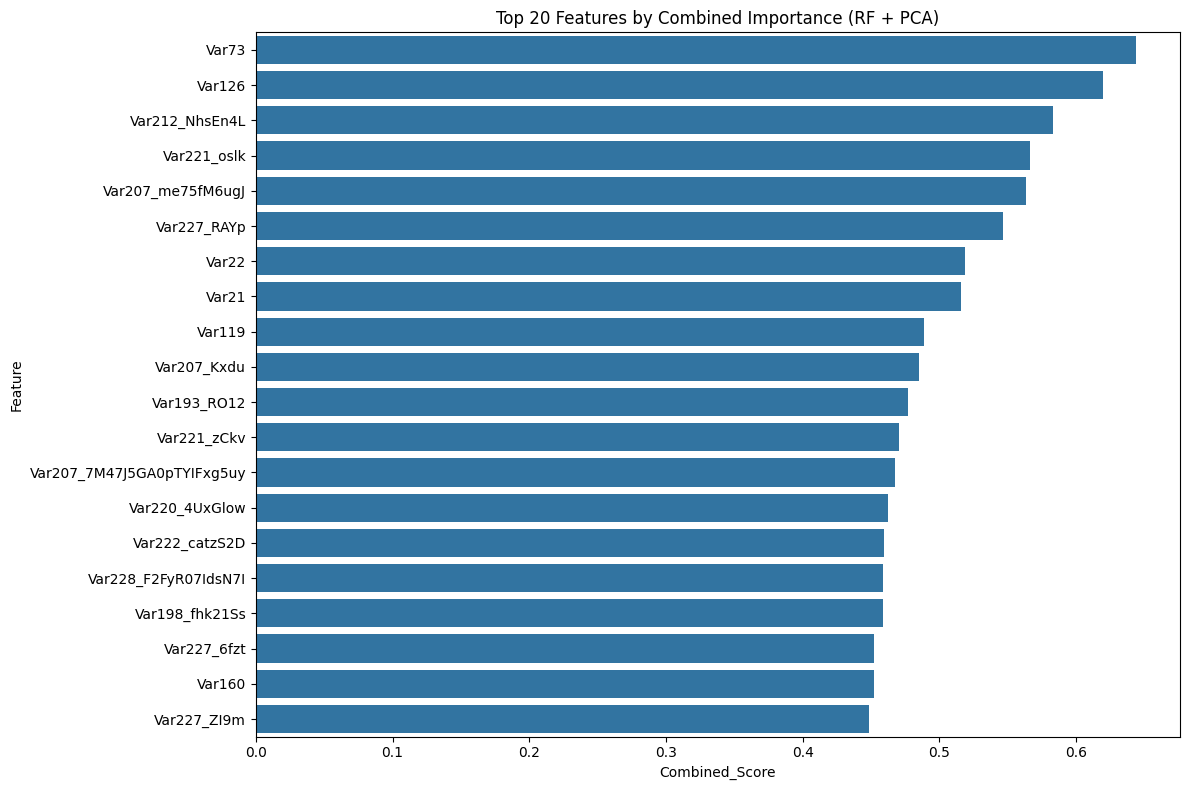

In [15]:
rf_top_features = feature_importance.head(20)['Feature'].tolist()
pca_top_features = pca_feature_importance.head(20)['Feature'].tolist()

common_features = set(rf_top_features).intersection(set(pca_top_features))

print(f"\nNumber of common features in top 20 between RF and PCA: {len(common_features)}")
print("Common important features:")
for feature in common_features:
    rf_rank = rf_top_features.index(feature) + 1
    pca_rank = pca_top_features.index(feature) + 1
    print(f"  - {feature} (RF rank: {rf_rank}, PCA rank: {pca_rank})")

feature_importance['RF_Importance_Normalized'] = feature_importance['Importance'] / feature_importance['Importance'].max()
pca_feature_importance['PCA_Importance_Normalized'] = pca_feature_importance['PCA_Importance'] / pca_feature_importance['PCA_Importance'].max()

combined_importance = pd.merge(
    feature_importance[['Feature', 'RF_Importance_Normalized']], 
    pca_feature_importance[['Feature', 'PCA_Importance_Normalized']], 
    on='Feature'
)

combined_importance['Combined_Score'] = (combined_importance['RF_Importance_Normalized'] + 
                                        combined_importance['PCA_Importance_Normalized']) / 2

combined_importance = combined_importance.sort_values('Combined_Score', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Combined_Score', y='Feature', data=combined_importance.head(20))
plt.title('Top 20 Features by Combined Importance (RF + PCA)')
plt.tight_layout()
plt.show()


## ML pipeline setup

In [16]:
print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

# 4 iteration
# Missing or zero values often have a systematic pattern.
# For instance, a client who hasn't filled anything out is more likely to churn.
train_df["num_missing"] = train_df.isnull().sum(axis=1)
train_df["num_zero"] = (train_df == 0).sum(axis=1)

test_df["num_missing"] = test_df.isnull().sum(axis=1)
test_df["num_zero"] = (test_df == 0).sum(axis=1)


#####
X = train_df.drop(columns=[TARGET], errors="ignore")
y = train_df[TARGET]

num_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_features = X.select_dtypes(include="object").columns.tolist()

Training data shape: (10000, 167)
Test data shape: (2500, 166)


In [17]:
numeric_transformer = Pipeline(
    [("imputer", KNNImputer(n_neighbors=7)), ("scaler", RobustScaler())]
)

categorical_transformer = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(
                handle_unknown="ignore", sparse_output=False, max_categories=20
            ),
        ),
    ]
)

preprocessor = ColumnTransformer(
    [
        ("num", numeric_transformer, num_features),
        ("cat", categorical_transformer, cat_features),
    ]
)


X_preprocessed = preprocessor.fit_transform(X)
test_preprocessed = preprocessor.transform(test_df)

rfecv = RFECV(
    estimator=LogisticRegression(max_iter=1000, solver="liblinear"),
    step=10,
    cv=StratifiedKFold(n_splits=2),
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=1,
)

rfecv.fit(X_preprocessed, y)

X_selected = X_preprocessed[:, rfecv.get_support()]
test_selected = test_preprocessed[:, rfecv.get_support()]

Fitting estimator with 573 features.
Fitting estimator with 573 features.
Fitting estimator with 563 features.
Fitting estimator with 563 features.
Fitting estimator with 553 features.
Fitting estimator with 543 features.
Fitting estimator with 553 features.
Fitting estimator with 533 features.
Fitting estimator with 543 features.
Fitting estimator with 523 features.
Fitting estimator with 513 features.
Fitting estimator with 533 features.
Fitting estimator with 503 features.
Fitting estimator with 493 features.
Fitting estimator with 523 features.
Fitting estimator with 483 features.
Fitting estimator with 473 features.
Fitting estimator with 513 features.
Fitting estimator with 463 features.
Fitting estimator with 453 features.
Fitting estimator with 503 features.
Fitting estimator with 443 features.
Fitting estimator with 433 features.
Fitting estimator with 493 features.
Fitting estimator with 423 features.
Fitting estimator with 413 features.
Fitting estimator with 483 features.
F

Selected 433 features out of 573 using RFECV


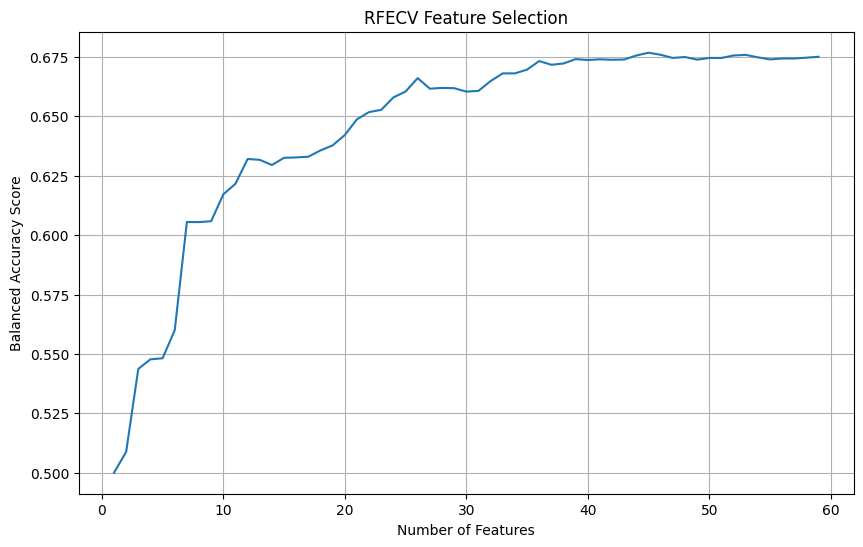

In [18]:
print(f"Selected {X_selected.shape[1]} features out of {X_preprocessed.shape[1]} using RFECV")
plt.figure(figsize=(10, 6))
plt.plot(
    range(1, len(rfecv.cv_results_["mean_test_score"]) + 1),
    rfecv.cv_results_["mean_test_score"],
)
plt.xlabel("Number of Features")
plt.ylabel("Balanced Accuracy Score")
plt.title("RFECV Feature Selection")
plt.grid()
plt.show()

In [19]:
# Class balancing
print(f"Class distribution before balancing: {np.bincount(y)}")
sampler = SMOTETomek(random_state=42, sampling_strategy=0.7)
X_balanced, y_balanced = sampler.fit_resample(X_selected, y)
print(f"Balanced classes after SMOTETomek: {np.bincount(y_balanced)}")

Class distribution before balancing: [8695 1305]
Balanced classes after SMOTETomek: [8691 6082]


In [20]:
param_grid = {
    "max_depth": [4, 5],
    "learning_rate": [0.02, 0.03],
    "scale_pos_weight": [6.5, 7],
}

xgb = XGBClassifier(
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.5,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
)

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    scoring="balanced_accuracy",
    n_jobs=-1,
    verbose=2,
)

print("Start GridSearchCV on X_balanced...")
grid.fit(X_balanced, y_balanced)

Start GridSearchCV on X_balanced...
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:33] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_meth

[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=6.5; total time=   2.9s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=6.5; total time=   3.1s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:35] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_la

[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=6.5; total time=  22.0s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:57] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:19:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method 

[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=7; total time=  27.4s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=7; total time=  27.5s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:00] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=7; total time=  27.5s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=6.5; total time=  27.6s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=6.5; total time=  27.8s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:00] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:20:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolas

[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=7; total time=  28.4s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=6.5; total time=  28.4s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=7; total time=  28.5s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=6.5; total time=  28.6s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=6.5; total time=  28.7s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=7; total time=  28.6s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:01] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:01] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=6.5; total time=  28.7s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=6.5; total time=  28.7s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=7; total time=  28.8s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=6.5; total time=  28.8s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=7; total time=  28.8s
[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=6.5; total time=  28.8s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.02, max_depth=4, scale_pos_weight=6.5; total time=  28.9s
[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=7; total time=  29.0s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.03, max_depth=4, scale_pos_weight=7; total time=  29.2s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:02] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=7; total time=  29.6s
[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=6.5; total time=  27.2s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=6.5; total time=  30.0s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:03] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:729: UserWarning: [14:20:03] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**k

[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=7; total time=  30.3s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=7; total time=  30.3s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=6.5; total time=  30.3s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=6.5; total time=  30.3s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=7; total time=  30.4s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=6.5; total time=  30.4s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=7; total time=  30.4s
[CV] END learning_rate=0.02, max_depth=5, scale_pos_weight=6.5; total time=  30.4s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=6.5; total time=  10.0s


/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:07] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/core.py:2676: UserWarning: [14:20:07] WARNING: /workspace/src/common/error

[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=7; total time=   7.4s
[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=7; total time=   7.3s
[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=7; total time=   7.1s
[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=7; total time=   7.1s
[CV] END learning_rate=0.03, max_depth=5, scale_pos_weight=7; total time=   7.0s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.8, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=0.5,
                                     grow_po...
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=3,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=300,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'learning_rate': [0.02, 0.03], 'max_depth': [4, 5],
                         'scale_pos_weight': [6.5, 7]},
             scoring='balanced_accuracy', verbose=2)

## Training on all data

In [21]:
best_params = grid.best_params_

final_model = XGBClassifier(
    **best_params,
    n_estimators=300,
    subsample=0.9,
    colsample_bytree=0.8,
    min_child_weight=3,
    gamma=0.5,
    use_label_encoder=False,
    eval_metric="logloss",
    tree_method="gpu_hist",
    predictor="gpu_predictor",
    random_state=42,
)

final_model.fit(X_balanced, y_balanced)

test_predictions = final_model.predict(test_selected)

submission_eval_df = pd.DataFrame({"index": range(len(y)), "y": final_model.predict(X_selected)})
solution_df = pd.DataFrame({"index": range(len(y)), "y": y})

print("\nBest parameters:")
print(best_params)
print(f"Balanced Accuracy: {grid.best_score_:.4f}")
print("Balanced accuracy (kaggle func): ", score(solution_df, submission_eval_df, row_id_column_name="index"))

submission_df = pd.DataFrame({"index": range(len(test_predictions)), "y": test_predictions})
submission_df.to_csv(os.path.join(PATH_TO_RESULTS, "submission.csv"), index=False, header=True)
print("Submission saved to: submission.csv")

display(submission_df.head(3))
display(submission_df.describe().T)


Best parameters:
{'learning_rate': 0.03, 'max_depth': 5, 'scale_pos_weight': 6.5}
Balanced Accuracy: 0.9244
Balanced accuracy (kaggle func):  0.9350040429277406
Submission saved to: submission.csv


,index,y
0,0,0
1,1,1
2,2,0


,count,mean,std,min,25%,50%,75%,max
index,2500.0,1249.5000,721.832160,0.0,624.75,1249.5,1874.25,2499.0
y,2500.0,0.2664,0.442164,0.0,0.00,0.0,1.00,1.0


## Overfitting checking

/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:20:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:20:09] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "predictor", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/nickolasz/Projects/GoIT/MACHINE-LEARNING-NEO/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [14:20:09] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_meth

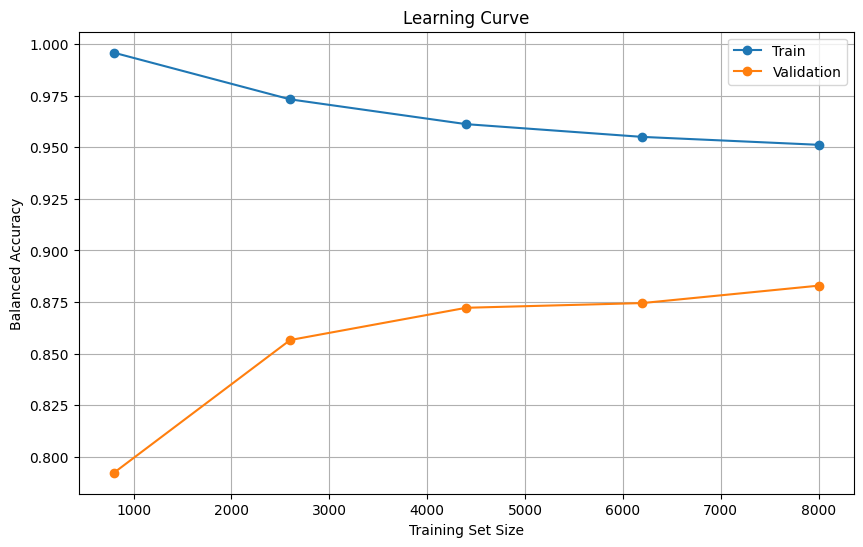

In [22]:
def check_overfitting(model, X_train, y_train):
    train_sizes, train_scores, val_scores = learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        scoring="balanced_accuracy",
        train_sizes=np.linspace(0.1, 1.0, 5),
        n_jobs=-1,
    )

    train_mean = np.mean(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label="Train", marker="o")
    plt.plot(train_sizes, val_mean, label="Validation", marker="o")
    plt.xlabel("Training Set Size")
    plt.ylabel("Balanced Accuracy")
    plt.title("Learning Curve")
    plt.grid()
    plt.legend()
    plt.show()

check_overfitting(final_model, X_selected, y)